# Download and unzip dataset

In [ ]:
!gdown 1ngSnT3CkIcgASQvrEvcED6jWkJTNWs-S

In [4]:
from zipfile import ZipFile
zf = ZipFile('dataset.zip', 'r')
zf.extractall('dataset')
zf.close()

In [5]:
mv dataset/Asirra\:\ cat\ vs\ dogs ./

In [6]:
rm -rf dataset/

# Import libraries

In [1]:
import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
import random
from os import listdir
from os.path import isfile, join
import random 

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose

import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import matplotlib.pyplot as plt

# Delete dogs images & labels

In [2]:
# directory_path = "Asirra: cat vs dogs/"

# files = os.listdir(directory_path)

# # Iterate through the files
# for file in files:
#     if "dog" in file:
#         file_path = os.path.join(directory_path, file)
#         os.remove(file_path)
#         #print(f"Deleted: {file_path}")

# print("Deletion complete.")

Deletion complete.


# Create New Dataset

In [2]:
# Function to parse the bounding box from the XML file
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for obj in root.iter('object'):
        if obj.find('name').text == 'cat':
            xmlbox = obj.find('bndbox')
            xmin = int(float(xmlbox.find('xmin').text))
            ymin = int(float(xmlbox.find('ymin').text))
            xmax = int(float(xmlbox.find('xmax').text))
            ymax = int(float(xmlbox.find('ymax').text))
            bboxes.append([xmin, ymin, xmax, ymax])
    return bboxes

In [3]:
# Function to calculate IOU
def get_iou(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

In [4]:
# Directories
image_dir = 'Asirra: cat vs dogs/'
positive_dir = 'new_dataset/positive_class'
negative_dir = 'new_dataset/negative_class'
os.makedirs(positive_dir, exist_ok=True)
os.makedirs(negative_dir, exist_ok=True)

# Iterate through the images and XMLs
for file in tqdm(os.listdir(image_dir)):
    if file.endswith('.jpg'):
        base_filename = file.split('/')[-1].split(".jpg")[0]
        img_path = os.path.join(image_dir, file)
        xml_path = os.path.join(image_dir, base_filename + '.xml')

        # Read image and parse XML
        img = cv2.imread(img_path)
        bboxes = parse_annotation(xml_path)

        # Apply Selective Search
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()

        # Iterate through region proposals
        for i, rect in enumerate(ssresults):
            x, y, w, h = rect
            proposal_bbox = [x, y, x+w, y+h]
            
            # Handle case when bboxes is empty
            if bboxes:
                max_iou = max([get_iou(proposal_bbox, gt_bbox) for gt_bbox in bboxes])
            else:
                max_iou = 0

            # Classify and save the proposal region
            if max_iou >= 0.5:
                save_path = os.path.join(positive_dir, f'{base_filename}_{i}-proposal-positive.jpg')
            else:
                save_path = os.path.join(negative_dir, f'{base_filename}_{i}-proposal-negative.jpg')
            cropped_img = img[y:y+h, x:x+w]
            cv2.imwrite(save_path, cropped_img)

100%|██████████| 2200/2200 [33:54<00:00,  1.08it/s] 


In [8]:
## Show Some sample of New Dataset

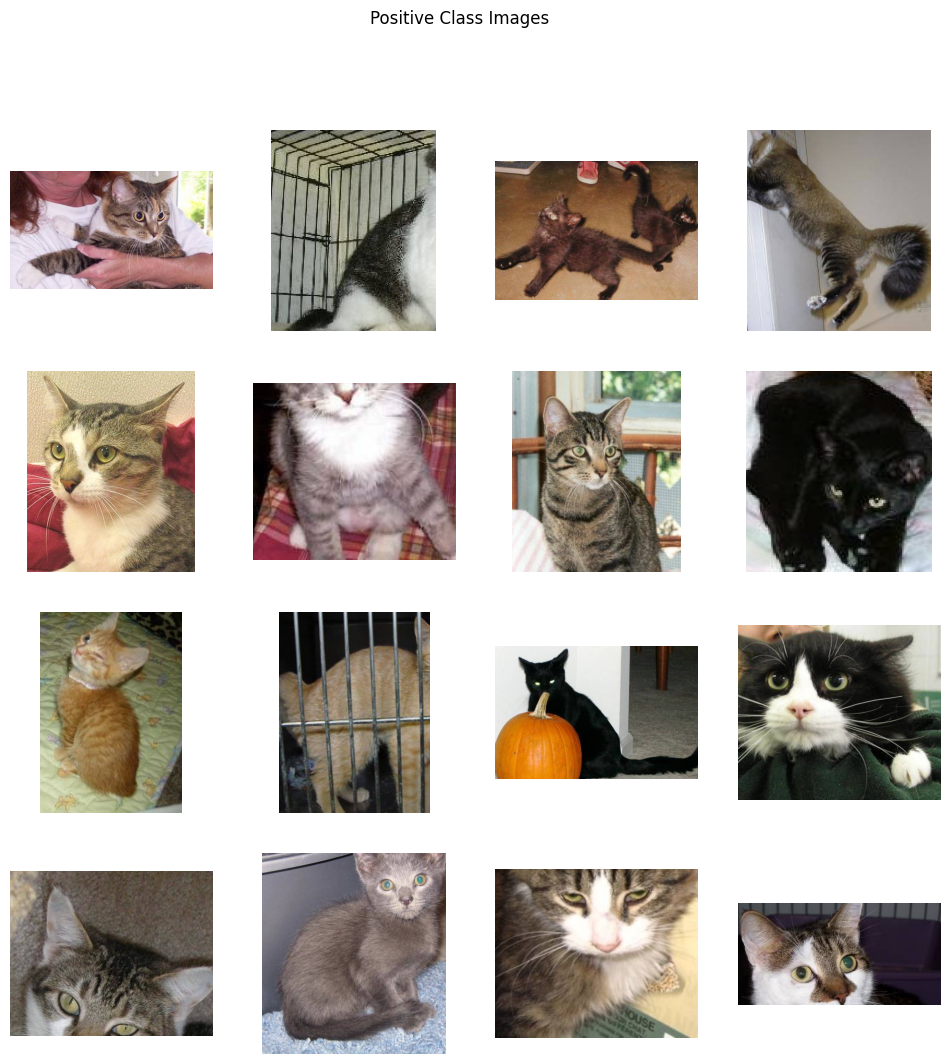

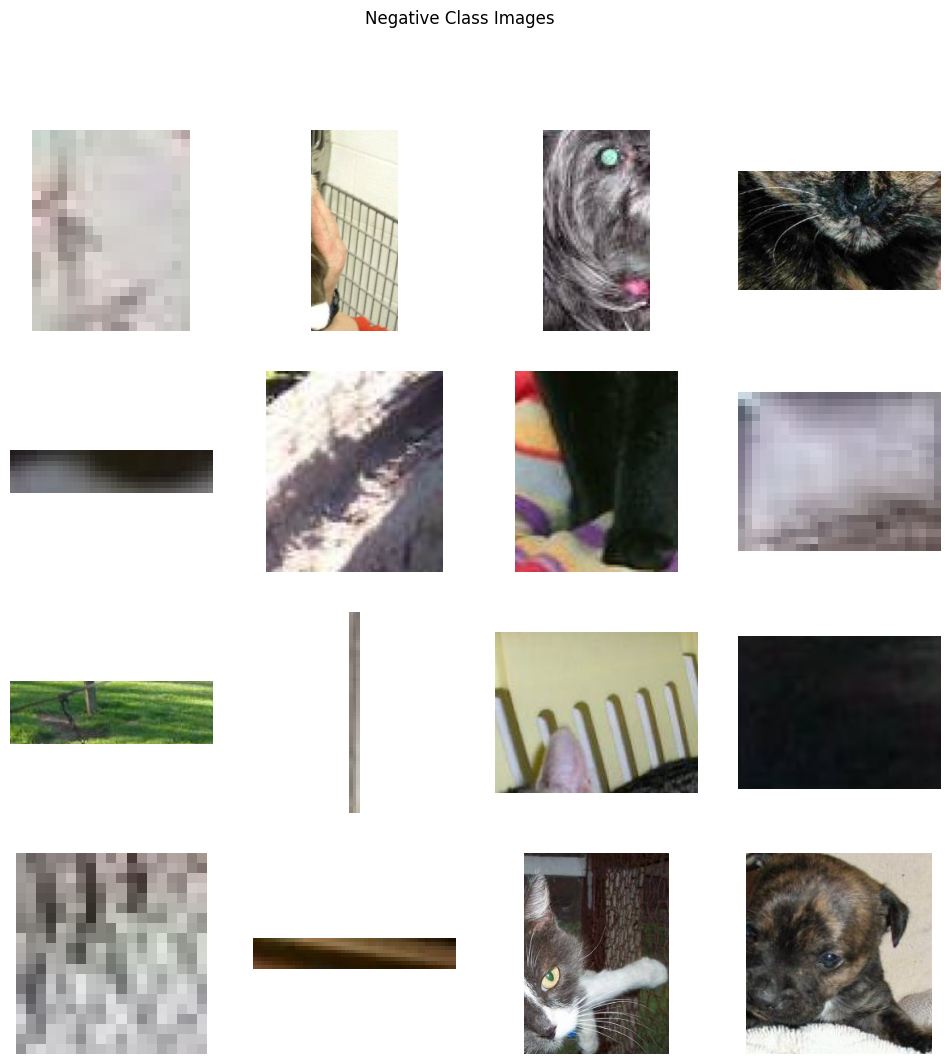

In [5]:
def show_random_images(directory, title, num_images=16):
    # Get all image files
    all_files = [f for f in listdir(directory) if isfile(join(directory, f))]
    selected_files = random.sample(all_files, min(num_images, len(all_files)))

    # Create a grid plot
    plt.figure(figsize=(12, 12))
    for i, file in enumerate(selected_files, 1):
        img = cv2.imread(join(directory, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

positive_dir = 'new_dataset/positive_class'
negative_dir = 'new_dataset/negative_class'

# Display images and print the count
show_random_images(positive_dir, 'Positive Class Images')
show_random_images(negative_dir, 'Negative Class Images')

In [6]:
positive_count = len([name for name in listdir(positive_dir) if isfile(join(positive_dir, name))])
negative_count = len([name for name in listdir(negative_dir) if isfile(join(negative_dir, name))])

print("positive_count : " , positive_count , "And Negative_count : " , negative_count)

positive_count :  15871 And Negative_count :  1099888


# Balance Dataset

In [7]:
# Assuming positive_count is known from the previous context
positive_count = 15871

# Path to the existing negative class directory and the new directory for balanced data
existing_negative_dir = 'new_dataset/negative_class'
new_negative_dir = 'new_dataset/negative_class_new'
os.makedirs(new_negative_dir, exist_ok=True)

# Get all negative image files
all_negative_files = [f for f in listdir(existing_negative_dir) if isfile(join(existing_negative_dir, f))]
selected_negative_files = random.sample(all_negative_files, positive_count)  # Selecting random files

# Copy selected files to the new directory
for file in tqdm(selected_negative_files):
    src_path = join(existing_negative_dir, file)
    dst_path = join(new_negative_dir, file)
    shutil.copy2(src_path, dst_path)

100%|██████████| 15871/15871 [00:17<00:00, 911.56it/s] 


# Train Mobilenet 

### load data

In [2]:
mv new_dataset/negative_class/ ./ 

In [3]:
# Define image transformations: resize to 224x224 and convert to tensor
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Create a custom dataset
dataset = ImageFolder(root='new_dataset/', transform=transform)


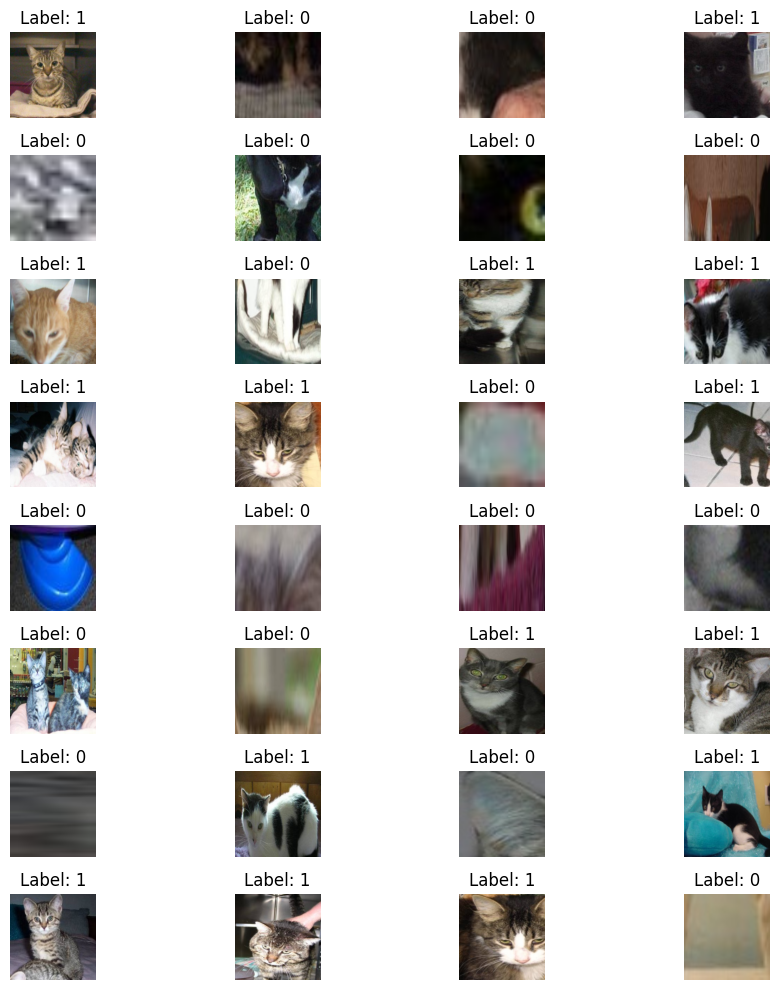

In [5]:
random.seed(42)

num_images = len(dataset)

# Choose 32 random indices
random_indices = random.sample(range(num_images), 32)

# Create a subplot with 8 rows and 4 columns
fig, axes = plt.subplots(8, 4, figsize=(10, 10))

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Loop through the random indices
for i, idx in enumerate(random_indices):
    image, label = dataset[idx]
    image = image.numpy().transpose((1, 2, 0))
    scaled_image = image * 255

    # Plot the image
    axes[i].imshow(scaled_image.astype('uint8'))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True , num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False , num_workers=1)


In [7]:
# Load the pre-trained MobileNet model
model = models.mobilenet_v2(pretrained=True)

# Freeze all the parameters in the feature network
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for 2 class classification
num_features = model.classifier[1].in_features
print(num_features)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 512), 
    nn.ReLU(), 
    nn.Dropout(0.2),
    nn.Linear(512, 2)  
)

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1280


In [8]:
# Check if GPU is available and move the model to GPU if it is
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model Loaded")

Model Loaded


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot([h.detach().cpu() for h in train_acc_history], label='Train Acc')
    plt.plot([h.detach().cpu() for h in val_acc_history], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([h for h in train_loss_history], label='Train Loss')
    plt.plot([h for h in val_loss_history], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    return model

Epoch 0/9
----------


100%|██████████| 695/695 [01:22<00:00,  8.46it/s]


train Loss: 0.3243 Acc: 0.9186


100%|██████████| 298/298 [00:35<00:00,  8.30it/s]


val Loss: 0.1345 Acc: 0.9557

Epoch 1/9
----------


100%|██████████| 695/695 [00:56<00:00, 12.22it/s]


train Loss: 0.2037 Acc: 0.9264


100%|██████████| 298/298 [00:24<00:00, 12.37it/s]


val Loss: 0.1342 Acc: 0.9515

Epoch 2/9
----------


100%|██████████| 695/695 [00:56<00:00, 12.38it/s]


train Loss: 0.1868 Acc: 0.9285


100%|██████████| 298/298 [00:23<00:00, 12.45it/s]


val Loss: 0.1400 Acc: 0.9549

Epoch 3/9
----------


100%|██████████| 695/695 [00:55<00:00, 12.42it/s]


train Loss: 0.1917 Acc: 0.9277


100%|██████████| 298/298 [00:24<00:00, 12.41it/s]


val Loss: 0.1418 Acc: 0.9551

Epoch 4/9
----------


100%|██████████| 695/695 [00:55<00:00, 12.43it/s]


train Loss: 0.1536 Acc: 0.9423


100%|██████████| 298/298 [00:24<00:00, 12.39it/s]


val Loss: 0.1151 Acc: 0.9595

Epoch 5/9
----------


100%|██████████| 695/695 [00:55<00:00, 12.42it/s]


train Loss: 0.1484 Acc: 0.9459


100%|██████████| 298/298 [00:24<00:00, 12.25it/s]


val Loss: 0.1058 Acc: 0.9625

Epoch 6/9
----------


100%|██████████| 695/695 [00:55<00:00, 12.42it/s]


train Loss: 0.1450 Acc: 0.9473


100%|██████████| 298/298 [00:24<00:00, 12.21it/s]


val Loss: 0.1060 Acc: 0.9612

Epoch 7/9
----------


100%|██████████| 695/695 [00:56<00:00, 12.39it/s]


train Loss: 0.1447 Acc: 0.9486


100%|██████████| 298/298 [00:24<00:00, 12.27it/s]


val Loss: 0.1073 Acc: 0.9599

Epoch 8/9
----------


100%|██████████| 695/695 [00:55<00:00, 12.42it/s]


train Loss: 0.1394 Acc: 0.9494


100%|██████████| 298/298 [00:24<00:00, 12.33it/s]


val Loss: 0.1053 Acc: 0.9603

Epoch 9/9
----------


100%|██████████| 695/695 [00:56<00:00, 12.38it/s]


train Loss: 0.1392 Acc: 0.9493


100%|██████████| 298/298 [00:24<00:00, 12.21it/s]


val Loss: 0.1023 Acc: 0.9623

Training complete in 14m 1s
Best val Acc: 0.962520


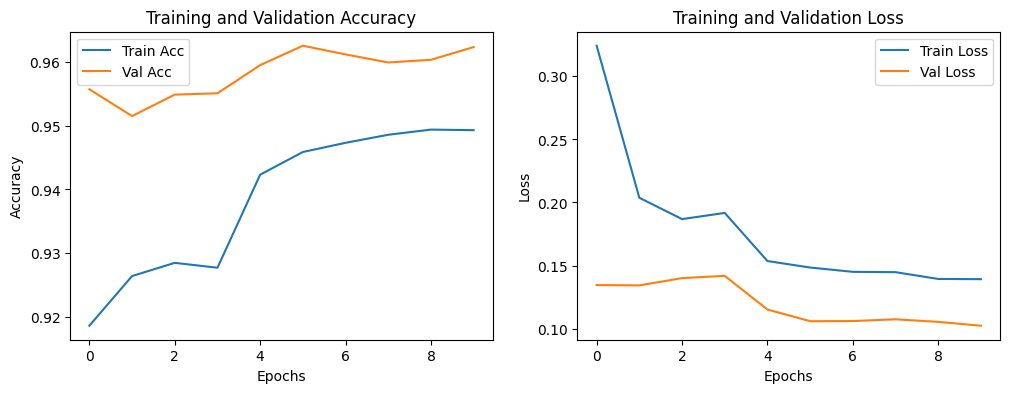

In [11]:
# Train the model
trained_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

In [12]:
# Save the model
torch.save(trained_model.state_dict(), 'mobilenet_detect_cat.pth')

In [ ]:
## Test on image

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load the pre-trained MobileNet model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for 2 class classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 512), 
    nn.ReLU(), 
    nn.Dropout(0.2),
    nn.Linear(512, 2)  
)

model.load_state_dict(torch.load('mobilenet_detect_cat.pth'))
model.eval()  
model.to(device)
print("model loaded")

model loaded


In [23]:
# Read the test image
img = cv2.imread('test2.jpg')

# Create a selective search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()  

OK
OK


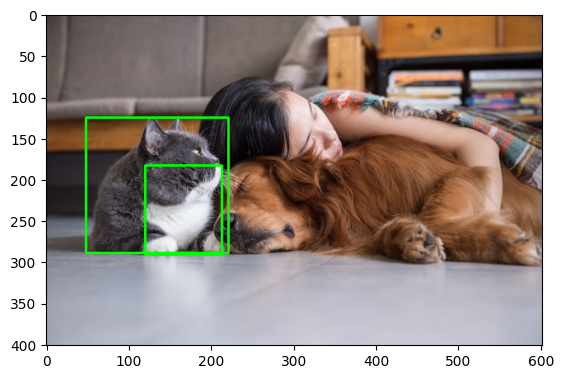

In [24]:
# Transform for input image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

i = 0
# Iterate over the regions and classify
for x, y, w, h in rects:
    roi = img[y:y+h, x:x+w]
    roi = transform(roi)
    roi = roi.unsqueeze(0).to(device) 
    output = model(roi)
    if (output[0, 0] < output[0, 1]):
        print("OK")
        i += 1
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        if i == 2:
            break

# Show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

OK
OK


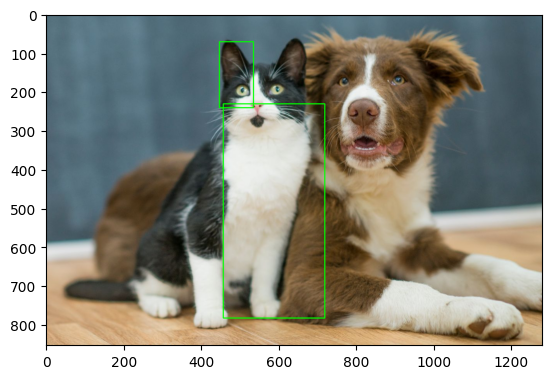

In [32]:
# Read the test image
img = cv2.imread('test1.jpg')

# Create a selective search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

# Transform for input image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

i = 0
# Iterate over the regions and classify
for x, y, w, h in rects:
    roi = img[y:y+h, x:x+w]
    roi = transform(roi)
    roi = roi.unsqueeze(0).to(device) 
    output = model(roi)
    if (output[0, 0] < output[0, 1]):
        print("OK")
        i += 1
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        if i == 2:
            break

# Show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()